In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle

from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

import warnings
warnings.filterwarnings("ignore")
from itertools import combinations, permutations, combinations_with_replacement
from preparation import *
from math import comb
sample_base = "MID_based_trees"
storagedir = "/home/hieunguyen/CRC1382/storage"
inputdir = os.path.join(storagedir, "BCR_bulk_trees", sample_base)
outdir = "/home/hieunguyen/CRC1382/outdir"

path_to_01_output = os.path.join(outdir, "BCR_bulk_trees", "01_output")
path_to_04_output = os.path.join(outdir, "BCR_bulk_trees", "04_output")
path_to_05_output = os.path.join(outdir, "BCR_bulk_trees", "05_output")
os.system("mkdir -p {}".format(path_to_05_output))

files = [item for item in pathlib.Path(inputdir).glob("*_full")]

list_of_samples = [item.name for item in files]

print("List of samples in this dataset: {}".format(list_of_samples))
print("***** ***** ***** ***** ***** ***** ***** ***** ***** *****")
print("Number of samples in this dataset: {}".format(len(list_of_samples)))

mid_metadata = pd.read_csv(os.path.join(storagedir, "BCR_bulk_trees", "mid_labels.csv"), sep=";", index_col = [0]) 
mid_metadata = mid_metadata.reset_index()
mid_metadata.columns = ["MID"] + list(mid_metadata.columns)[1:]

mid_metadata = mid_metadata.drop([item for item in mid_metadata.columns if "Unnamed" in item], axis = 1)

mid_metadata["YFP"] = mid_metadata["population"].apply(lambda x: x[5:] if "YFP" in x else "notgiven")
mid_metadata["day_and_age"] = mid_metadata[["day", "age"]].apply(lambda x: "8w_d90" if "{}_{}".format(x[1], x[0]) == "9w_d90" else "{}_{}".format(x[1], x[0]), axis = 1)

/home/hieunguyen/miniconda3/envs/ete3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


List of samples in this dataset: ['MID33_full', 'MID25_full', 'MID46_full', 'MID63_full', 'MID61_full', 'MID10_full', 'MID31_full', 'MID49_full', 'MID1_full', 'MID17_full', 'MID35_full', 'MID36_full', 'MID68_full', 'MID52_full', 'MID13_full', 'MID51_full', 'MID45_full', 'MID67_full', 'MID48_full', 'MID28_full', 'MID2_full', 'MID58_full', 'MID43_full', 'MID55_full', 'MID3_full', 'MID29_full', 'MID54_full', 'MID18_full', 'MID40_full', 'MID16_full', 'MID34_full', 'MID12_full', 'MID11_full', 'MID69_full', 'MID60_full', 'MID9_full', 'MID14_full', 'MID4_full', 'MID59_full', 'MID47_full', 'MID26_full', 'MID38_full', 'MID24_full', 'MID32_full', 'MID15_full', 'MID5_full', 'MID23_full', 'MID50_full', 'MID66_full', 'MID44_full', 'MID57_full', 'MID65_full', 'MID53_full', 'MID30_full', 'MID8_full', 'MID64_full', 'MID62_full', 'MID39_full', 'MID6_full', 'MID42_full', 'MID7_full']
***** ***** ***** ***** ***** ***** ***** ***** ***** *****
Number of samples in this dataset: 61


In [3]:
os.system("mkdir -p {}".format(os.path.join(path_to_05_output, "count_label_dfs")))
for samplename in tqdm(list_of_samples):
    path_to_sample = os.path.join(inputdir, samplename)
    all_trees = [item for item in pathlib.Path(path_to_sample).glob("*") if os.path.isdir(item)]
    
    for treedir in tqdm(all_trees):    
        tree_name = samplename + "_" + treedir.name
        treedir = str(treedir)
        nk_path = os.path.join(treedir, "gctree.out.inference.1.nk")
        if os.path.exists(nk_path) == True:
            ab_dict_path = os.path.join(treedir, "abund.csv")
            abund_df = pd.read_csv(ab_dict_path, index_col=0, names=['val'])
            ab_dict = abund_df.to_dict().get('val')
            tree_path = treedir
            tree = Tree(newick=nk_path, format=1)
            if ab_dict is not None:
                for node in tree.traverse():
                    node.add_feature('abundance', ab_dict.get(node.name, 0))
            treeobj = GCtree(tree = tree, path = tree_path)
        all_nodes = treeobj.nodes
        
        node_dict = dict()
        for node in all_nodes:
            node_dict[node.name] = node
        
        # colormap = treeobj.feature_colormap("abundance")
        # treeobj.render("%%inline", colormap=colormap)
        
        nodedf = pd.DataFrame(data = [item.name for item in all_nodes], columns = ["node_name"])
        nodedf["children"] = nodedf["node_name"].apply(lambda x: ", ".join([item.name for item in node_dict[x].get_children()]))
        nodedf["num_children"] = nodedf["node_name"].apply(lambda x: len([item.name for item in node_dict[x].get_children() ]))
        
        max_multifurcation = np.max(nodedf["num_children"].to_numpy())
        
        ordered_nodes = []
        for node in tree.traverse():
            ordered_nodes.append(node.name)
        
        list.reverse(ordered_nodes)
        
        label = dict()
        for node in ordered_nodes:
            childrens = node_dict[node].get_children()
            if len(childrens) == 0:
                label[node] = 1
            else:
                label[node] = []
                for child in childrens:
                    label[node].append(label[child.name])
                if len(label[node]) < max_multifurcation:
                    label[node] += [0 for item in range(max_multifurcation - len(label[node]))]
                label[node] = sorted(label[node], reverse = True)
                label[node] = sum([comb(x + (i + 1) -1, (i + 1)) for (i, x) in enumerate(label[node])])
        nodedf["label"] = nodedf["node_name"].apply(lambda x: label[x])
        tmp_countdf = nodedf.groupby("label")["node_name"].count().reset_index()
        tmp_countdf.columns = ["label", tree_name]
        
        tmp_countdf.to_csv(os.path.join(path_to_05_output, "count_label_dfs", tree_name + ".csv"))


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 330.47it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 335.29it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 258.01it/s]

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 283.51it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 215.46it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 330.15it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 297.28it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 177.03it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 255.99it/s]

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 277.14it/s]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 161.46it/s]

100%|███████████████████████████████████████████| 61/61 [00:19<00:00,  3.19it/s]


In [4]:
if os.path.isfile(os.path.join(path_to_05_output, "tree_distance_matrix.csv")) == False:
    tqdm.pandas()
    all_trees = [item for item in pathlib.Path(os.path.join(path_to_05_output, "count_label_dfs")).glob("*.csv")]
    treedf = pd.DataFrame(data = sorted([item.name.replace(".csv", "") for item in all_trees]), columns = ["tree_name"])
    
    def calculate_dist(tree1, tree2):
        tree1df = pd.read_csv(os.path.join(path_to_05_output, "count_label_dfs", "{}.csv".format(tree1)), index_col = [0])
        tree2df = pd.read_csv(os.path.join(path_to_05_output, "count_label_dfs", "{}.csv".format(tree2)), index_col = [0])
        
        mergedf = tree1df.merge(tree2df, right_on = "label", left_on = "label", how = "outer")
        mergedf = mergedf.fillna(0)
        
        return(np.linalg.norm(mergedf[tree1].to_numpy() - mergedf[tree2].to_numpy()))
        
    for tree in tqdm(treedf.tree_name.unique()):
        treedf[tree] = treedf["tree_name"].apply(lambda x: calculate_dist(x, tree) if x != tree else 0)
    
    treedf.to_csv(os.path.join(path_to_05_output, "tree_distance_matrix.csv"))
else:
    treedf = pd.read_csv(os.path.join(path_to_05_output, "tree_distance_matrix.csv"), index_col = [0])

100%|████████████████████████████████████| 5222/5222 [19:41:27<00:00, 13.57s/it]


In [5]:
from sklearn.manifold import MDS

In [7]:
if os.path.isfile(os.path.join(path_to_05_output, "MDS.csv")) == False:
    X = treedf.drop(["tree_name"], axis = 1).to_numpy()
    embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(X)
    mdsdf = pd.DataFrame(data = X_transformed, columns = ["MDS1", "MDS2"])
    mdsdf.to_csv(os.path.join(path_to_05_output, "MDS.csv"))
else:
    mdsdf = pd.read_csv(os.path.join(path_to_05_output, "MDS.csv"), index_col = [0])

In [12]:
mdsdf["tree_name"] = [item for item in treedf.columns if item != "tree_name"]
mdsdf["MID"] = mdsdf["tree_name"].apply(lambda x: x.split("_full")[0])

In [14]:
mdsdf["day"] = mdsdf["mouse"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["day"].unique()[0])
mdsdf["age"] = mdsdf["mouse"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["age"].unique()[0])
mdsdf["population"] = mdsdf["mouse"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].unique()[0])

<Axes: xlabel='MDS1', ylabel='MDS2'>

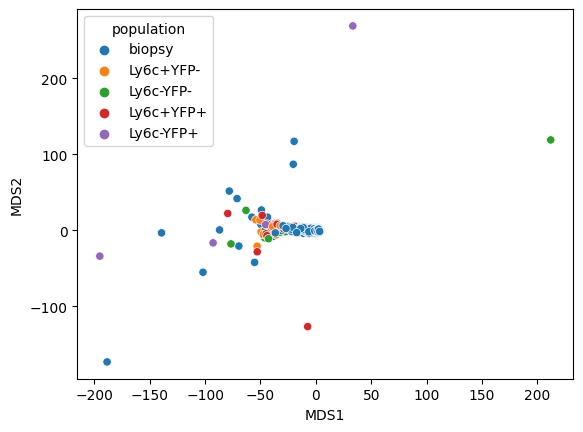

In [17]:
sns.scatterplot(data = mdsdf, x = "MDS1", y = "MDS2", hue = "population")